In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl
import seaborn as sns

%matplotlib inline

In [4]:
df = pd.read_pickle("./pkls/coa_data.pkl")

<h3>Next goal:</h3> </br>
<p> Take all the coas and pull out the terpenoid and heavy metal test results, if any, and make a new dataframe contianing amounts of all analytes as columns and each sample with these kind of test results as the rows</p></br>

In [36]:
df.columns

Index(['coa_data', 'has_cannabinoid_test', 'has_terpenoid_test',
       'has_pesticide_test', 'has_residual_solvent_test',
       'has_heavy_metal_test', 'has_microbial_test', 'has_mycotoxin_test',
       'has_foreign_material_test', 'has_homogeneity_test',
       'has_moisture_test', 'has_water_activity_test',
       'has_cannabinoid_and_terpenoid_test',
       'has_heavy_metal_and_terpenoid_test'],
      dtype='object')

In [37]:
df_heavy_metal_and_terp = df[(df['has_heavy_metal_and_terpenoid_test'] == True)]

In [5]:
df_terp = df[(df['has_terpenoid_test'] == True)] 
df_heavy_metal = df[(df['has_heavy_metal_test'] == True)]

In [39]:
print(df_heavy_metal.shape)
print(df_terp.shape)
print(df_heavy_metal_and_terp.shape)


(6460, 14)
(1819, 14)
(1479, 14)


<h5>Make heavy metals dataframe, then save it</h5>

In [9]:
df_hm_results = pd.DataFrame()
for index, row in df_heavy_metal.iterrows():
    
    #Check if entry a dict or list containing the one dict, because both formats will appear
    is_dict = type(row['coa_data']['heavy_metal_test']) is dict
    #print(is_dict)
    
    #pull out test results for this test type
    hm_results = row['coa_data']['heavy_metal_test']['results'] if is_dict else row['coa_data']['heavy_metal_test'][0]['results']

    #create new df from retrieved dictionary so that it can be merged with data from other rows,
    #then keep only the row "amount"
    temp_df = pd.DataFrame.from_dict(hm_results)
    temp_df = temp_df[temp_df.index == 'amount'].reset_index()
    df_hm_results = df_hm_results.append(temp_df, ignore_index = True)


print(df_hm_results.head())

    index Arsenic Cadmium   Lead Mercury
0  amount   0.015   0.015  0.058   < LOQ
1  amount   < LOQ       0  0.049   < LOQ
2  amount       0       0  0.039   < LOQ
3  amount       0       0  0.114   < LOQ
4  amount       0       0  0.063   < LOQ


In [7]:
print(temp_df)

                                                            Arsenic  \
amount                                                        0.117   
analyte                                                     Arsenic   
detection_limits  {'LOD': {'amount': 0.004, 'units': 'µg/g'}, 'L...   
passed                                                         True   
units                                                          µg/g   

                                                            Cadmium  \
amount                                                        0.029   
analyte                                                     Cadmium   
detection_limits  {'LOD': {'amount': 0.004, 'units': 'µg/g'}, 'L...   
passed                                                         True   
units                                                          µg/g   

                                                               Lead  \
amount                                                        0.306   
anal

<h5>Drop duplicate entries and look at stats before and after</h5>

In [55]:
print(df_hm_results.describe())
print(df_hm_results.dtypes)
df_hm_results = df_hm_results.drop_duplicates()
df_hm_results.describe()

         index  Arsenic  Cadmium  Lead  Mercury
count     6460     6460     6460  6460     6460
unique       1      233      228   512       83
top     amount        0        0     0        0
freq      6460     2725     3638  1071     3177
index      object
Arsenic    object
Cadmium    object
Lead       object
Mercury    object
dtype: object


,index,Arsenic,Cadmium,Lead,Mercury
count,3406,3406,3406,3406,3406
unique,1,233,228,512,83
top,amount,0,0,< LOQ,0
freq,3406,730,1175,240,996


<h5>Clean out strings and convert data to float type</h5>

In [56]:
df_hm_results = df_hm_results.drop('index', axis=1)
for column in df_hm_results.columns:
    df_hm_results[column].replace(['< LOQ', '<LOQ'], 0, inplace=True)

In [59]:
df_hm_results = df_hm_results.astype('float64')

In [60]:
df_hm_results.describe()

,Arsenic,Cadmium,Lead,Mercury
count,3406.000000,3406.000000,3406.000000,3406.000000
mean,0.039260,0.031488,293.801531,0.009260
std,0.160743,0.126997,17134.742853,0.037186
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.022000,0.000000
50%,0.012000,0.002000,0.051000,0.000000
75%,0.030000,0.024000,0.130000,0.013000
max,4.730000,3.680000,1000000.000000,2.000000


<h5>Save dataframe</h5>

In [131]:
df_hm_results.to_pickle('./cleaned_hm_results.pkl')

<h5>Create terpenoid dataframe and save it</h5>

In [64]:
df_terp_results = pd.DataFrame()
not_included = 0
for index, row in df_terp.iterrows():
    
    #Check if entry a dict or list containing the one dict, because both formats will appear
    is_dict = type(row['coa_data']['terpenoid_test']) is dict
    #print(is_dict)
    
    #pull out test results for this test type
    terp_results = row['coa_data']['terpenoid_test']['results'] if is_dict else row['coa_data']['terpenoid_test'][0]['results']
    
    if (type(terp_results) is not dict):
        not_included += 1
        continue
        
    #create new df from retrieved dictionary so that it can be merged with data from other rows,
    #then keep only the row "amount"
    temp_df = pd.DataFrame.from_dict(terp_results)
    temp_df = temp_df[temp_df.index == 'amount'].reset_index()
    df_terp_results = df_terp_results.append(temp_df, ignore_index = True)

print(not_included)
print(df_terp_results.head())

/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


3
  1,8-Cineole Camphene Caryophyllene Oxide Delta-3-Carene Geraniol Guaiol  \
0           0        0                 NaN              0        0      0   
1           0        0                 NaN              0        0      0   
2           0        0                 NaN              0        0      0   
3           0        0                 NaN              0        0      0   
4           0        0                 NaN              0        0      0   

  Isopulegol Linalool Terpinolene alpha-Bisabolol       ...        \
0          0   0.3068           0         0.07937       ...         
1          0  0.08907           0         0.11511       ...         
2          0    0.074           0         0.05487       ...         
3          0  0.05412           0               0       ...         
4          0  0.40387      0.0835               0       ...         

  beta-Caryophyllene beta-Myrcene beta-Ocimene beta-Pinene cis-Nerolidol  \
0            1.74193      0.09276           

<h5>Data cleaning step</h5>

In [65]:
print(df_terp_results.describe())
print(df_terp_results.dtypes)
df_terp_results = df_terp_results.drop_duplicates()
df_terp_results = df_terp_results.drop('index', axis=1)
for column in df_terp_results.columns:
    df_terp_results[column].replace(['< LOQ', '<LOQ'], 0, inplace=True)
df_terp_results = df_terp_results.astype('float64')
df_terp_results.describe()

        1,8-Cineole  Camphene  Caryophyllene Oxide  Delta-3-Carene  Geraniol  \
count        1776.0    1815.0                630.0          1815.0    1815.0   
unique         51.0     334.0                 89.0           143.0      60.0   
top             0.0       0.0                  0.0             0.0       0.0   
freq         1690.0    1362.0                504.0          1629.0    1742.0   

        Guaiol  Isopulegol  Linalool  Terpinolene  alpha-Bisabolol  \
count   1803.0      1815.0    1816.0       1815.0           1802.0   
unique   347.0        16.0    1506.0        434.0           1101.0   
top        0.0         0.0       0.0          0.0              0.0   
freq    1434.0      1778.0     208.0       1288.0            529.0   

             ...         beta-Caryophyllene  beta-Myrcene  beta-Ocimene  \
count        ...                     1816.0        1816.0        1776.0   
unique       ...                     1690.0        1524.0         802.0   
top          ...       

,"1,8-Cineole",Camphene,Caryophyllene Oxide,Delta-3-Carene,Geraniol,Guaiol,Isopulegol,Linalool,Terpinolene,alpha-Bisabolol,...,alpha-Terpinene,beta-Caryophyllene,beta-Myrcene,beta-Ocimene,beta-Pinene,cis-Nerolidol,d-Limonene,gamma-Terpinene,p-Cymene,trans-Nerolidol
count,1744.000000,1783.000000,603.000000,1783.000000,1783.000000,1771.000000,1783.000000,1784.000000,1783.000000,1770.000000,...,1783.000000,1784.000000,1784.000000,1744.000000,1783.000000,1783.000000,1784.000000,1783.000000,1783.000000,1782.000000
mean,0.049222,0.019923,0.032570,0.036198,0.002369,0.021694,0.000254,0.347069,0.146973,0.098570,...,0.005114,1.075321,0.249464,0.073764,0.778644,0.022924,0.928034,0.004797,0.011629,0.026395
std,1.732177,0.160735,0.243696,0.657860,0.035152,0.103810,0.004331,1.638962,0.552370,0.350804,...,0.037423,2.427852,0.931681,0.189371,1.555100,0.200754,3.607229,0.034208,0.140703,0.137764
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070068,0.000000,0.000000,...,0.000000,0.323950,0.072665,0.000000,0.133970,0.000000,0.185035,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.172450,0.000000,0.055855,...,0.000000,0.621295,0.136490,0.001580,0.376590,0.000000,0.500270,0.000000,0.000000,0.000000
75%,0.000000,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.362310,0.005000,0.104652,...,0.000000,1.033997,0.218355,0.073307,0.874790,0.000000,0.881060,0.000000,0.000000,0.015000
max,71.375330,6.209930,4.830000,23.896710,1.134820,3.509000,0.151000,63.734370,6.097040,8.858490,...,1.287280,42.927220,31.252780,3.414000,28.227990,3.078000,130.992540,0.768000,3.710000,4.443140


<h5>Save dataframe</h5>

In [66]:

df_terp_results.to_pickle('./cleaned_terp_results.pkl')

In [98]:
for index, row in df_heavy_metal_and_terp.iterrows():
    #print(row)
    
    #Check if entry a dict or list containing the one dict, because both formats will appear
    is_dict = type(row['coa_data']['terpenoid_test']) is dict

    #pull out test results for this test type
    terp_results = row['coa_data']['terpenoid_test']['results'] if is_dict else row['coa_data']['terpenoid_test'][0]['results']
    
print(terp_results['alpha-Pinene']['units'])

%


<h5>Now create combined heavy metals and terpinoids dataframe</h5> 

In [72]:
df_hm_terp_results = pd.DataFrame()
not_included = 0
for index, row in df_heavy_metal_and_terp.iterrows():
    #print(row)
    
    #Check if entry a dict or list containing the one dict, because both formats will appear
    is_dict = type(row['coa_data']['terpenoid_test']) is dict

    #pull out test results for this test type
    terp_results = row['coa_data']['terpenoid_test']['results'] if is_dict else row['coa_data']['terpenoid_test'][0]['results']

    if (type(terp_results) is not dict):
        not_included += 1
        continue
    is_dict = type(row['coa_data']['heavy_metal_test']) is dict    
    #pull out test results for this test type
    hm_results = row['coa_data']['heavy_metal_test']['results'] if is_dict else row['coa_data']['heavy_metal_test'][0]['results']
    
    #create new df from retrieved dictionary so that it can be merged with data from other rows,
    #then keep only the row "amount"
    temp_terp_df = pd.DataFrame.from_dict(terp_results)
    temp_terp_df = temp_terp_df[temp_terp_df.index == 'amount'].reset_index()
    temp_hm_df = pd.DataFrame.from_dict(hm_results)
    temp_hm_df = temp_hm_df[temp_hm_df.index == 'amount'].reset_index()
    temp_df = pd.merge(temp_terp_df, temp_hm_df, on=['index'], how='outer')
    #print(temp_df)
    #temp_df = temp_df[temp_df.index == 'amount'].reset_index()
    df_hm_terp_results = df_hm_terp_results.append(temp_df, ignore_index = True)

print(not_included)
print(df_hm_terp_results.head())

/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


2
  1,8-Cineole Arsenic Cadmium Camphene Caryophyllene Oxide Delta-3-Carene  \
0           0   < LOQ       0        0                 NaN              0   
1           0       0       0        0                 NaN              0   
2           0       0       0        0                 NaN              0   
3           0       0       0        0                 NaN              0   
4           0   < LOQ   0.014        0                 NaN              0   

  Geraniol Guaiol Isopulegol   Lead       ...       beta-Caryophyllene  \
0        0      0          0  0.049       ...                  1.74193   
1        0      0          0  0.039       ...                  1.31326   
2        0      0          0  0.114       ...                  0.77173   
3        0      0          0  0.063       ...                  0.29006   
4        0      0          0  < LOQ       ...                  0.52539   

  beta-Myrcene beta-Ocimene beta-Pinene cis-Nerolidol d-Limonene  \
0      0.09276        

<h5>Data Cleaning Step</h5>

In [73]:
print(df_hm_terp_results.describe())
print(df_hm_terp_results.dtypes)
df_hm_terp_results = df_hm_terp_results.drop_duplicates()
df_hm_terp_results = df_hm_terp_results.drop('index', axis=1)
for column in df_hm_terp_results.columns:
    df_hm_terp_results[column].replace(['< LOQ', '<LOQ'], 0, inplace=True)
df_hm_terp_results = df_hm_terp_results.astype('float64')
df_hm_terp_results.describe()

        1,8-Cineole  Arsenic  Cadmium  Camphene  Caryophyllene Oxide  \
count        1438.0     1477     1477    1476.0                377.0   
unique         32.0      101      115     260.0                 53.0   
top             0.0        0        0       0.0                  0.0   
freq         1394.0      592      821    1173.0                309.0   

        Delta-3-Carene  Geraniol  Guaiol  Isopulegol   Lead       ...         \
count           1476.0    1476.0  1464.0      1476.0   1477       ...          
unique           107.0      38.0   277.0         6.0    202       ...          
top                0.0       0.0     0.0         0.0  < LOQ       ...          
freq            1358.0    1435.0  1182.0      1470.0    233       ...          

        beta-Caryophyllene  beta-Myrcene  beta-Ocimene  beta-Pinene  \
count               1477.0        1477.0        1438.0       1476.0   
unique              1423.0        1318.0         681.0       1379.0   
top                    0.

,"1,8-Cineole",Arsenic,Cadmium,Camphene,Caryophyllene Oxide,Delta-3-Carene,Geraniol,Guaiol,Isopulegol,Lead,...,alpha-Terpinene,beta-Caryophyllene,beta-Myrcene,beta-Ocimene,beta-Pinene,cis-Nerolidol,d-Limonene,gamma-Terpinene,p-Cymene,trans-Nerolidol
count,1435.000000,1474.000000,1474.000000,1473.000000,374.000000,1473.000000,1473.000000,1461.000000,1473.000000,1474.000000,...,1473.000000,1474.000000,1474.000000,1435.000000,1473.000000,1473.000000,1474.000000,1473.000000,1473.000000,1472.000000
mean,0.000361,0.013385,0.012277,0.009683,0.006943,0.008690,0.001710,0.017694,0.000068,0.047687,...,0.003974,0.857321,0.189490,0.067935,0.651174,0.005058,0.706510,0.003858,0.000317,0.017867
std,0.004628,0.028950,0.041187,0.027746,0.038369,0.054026,0.030777,0.049880,0.001942,0.106888,...,0.018988,1.128511,0.226687,0.144979,0.847744,0.034795,0.950860,0.028573,0.006976,0.056463
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.377797,0.080057,0.000000,0.142770,0.000000,0.216755,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022500,...,0.000000,0.647550,0.146000,0.001370,0.367830,0.000000,0.542765,0.000000,0.000000,0.000000
75%,0.000000,0.014000,0.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,...,0.000000,1.025035,0.217060,0.072375,0.868750,0.000000,0.887768,0.000000,0.000000,0.009000
max,0.137010,0.313000,0.722000,0.232130,0.630000,0.986930,1.134820,0.875170,0.071000,1.630000,...,0.209870,32.039000,3.258180,1.635680,14.808860,0.615000,22.794000,0.768000,0.247360,1.199860


<h5>Save Dataframe</h5>

In [74]:
df_hm_terp_results.to_pickle('./cleaned_hm_terp_results.pkl')

<h5>Reload dataframes from pkl files</h5>

In [12]:
df_hm_terp_results = pd.read_pickle("./pkls/cleaned_hm_terp_results.pkl")
df_terp_results = pd.read_pickle("./pkls/cleaned_terp_results.pkl")
df_hm_results = pd.read_pickle("./pkls/cleaned_hm_results.pkl")

<h5> Correlation map for terpenes and heavy metals </h5>

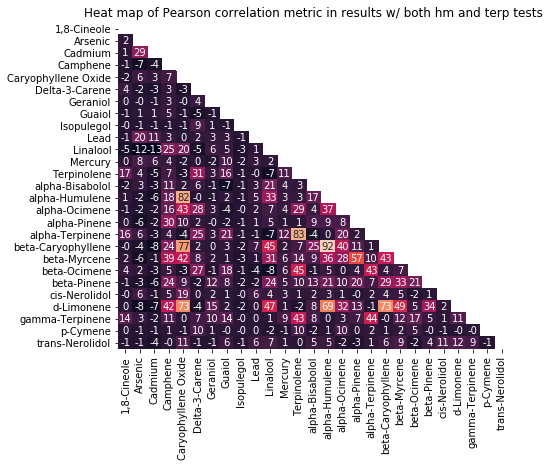

In [309]:
pp = PdfPages('multipage_hm_AND_terpenoid.pdf')
correlations = df_hm_terp_results.corr()
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(7,6))
plt.title('Heat map of Pearson correlation metric in results w/ both hm and terp tests')

corr_heat = sns.heatmap(correlations * 100, annot=True, fmt='.0f', mask=mask, cbar=False)
pp.savefig()
pp.close()

Text(0.5,1,'Amount Lead vs Arsenic, corr=20')

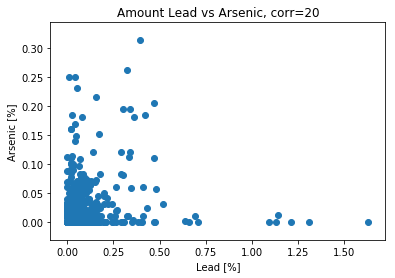

In [89]:
plt.scatter(df_hm_terp_results['Lead'], df_hm_terp_results['Arsenic'])
fig_size = [7,6]
plt.xlabel('Lead [%]')
plt.ylabel('Arsenic [%]')
plt.title('Amount Lead vs Arsenic, corr=20')


Text(0.5,1,'Amount Cadmium vs Arsenic, corr=29')

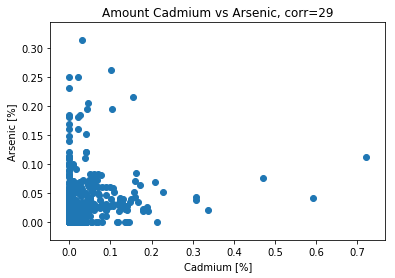

In [88]:
plt.scatter(df_hm_terp_results['Cadmium'], df_hm_terp_results['Arsenic'])
fig_size = [7,6]
plt.xlabel('Cadmium [%]')
plt.ylabel('Arsenic [%]')
plt.title('Amount Cadmium vs Arsenic, corr=29')

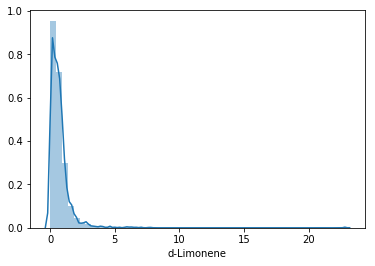

In [92]:
sns.distplot(df_hm_terp_results['d-Limonene'])

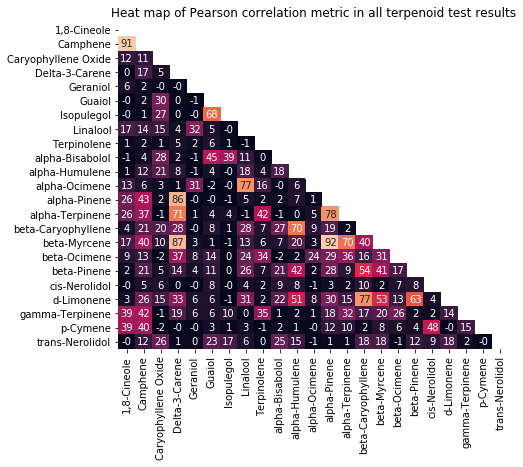

In [308]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage_terpenoid.pdf')
correlations = df_terp_results.corr()
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(7,6))
plt.title('Heat map of Pearson correlation metric in all terpenoid test results')

corr_heat = sns.heatmap(correlations * 100, annot=True, fmt='.0f', mask=mask, cbar=False)
pp.savefig()
pp.close()

      1,8-Cineole  Camphene  Caryophyllene Oxide  Delta-3-Carene  Geraniol  \
1634          0.0       0.0                  NaN             0.0       0.0   

      Guaiol  Isopulegol  Linalool  Terpinolene  alpha-Bisabolol  \
1634     0.0         0.0   1.33619          0.0              0.0   

           ...         alpha-Terpinene  beta-Caryophyllene  beta-Myrcene  \
1634       ...                     0.0                 0.0           0.0   

      beta-Ocimene  beta-Pinene  cis-Nerolidol  d-Limonene  gamma-Terpinene  \
1634       0.41336      3.19546            0.0   130.99254              0.0   

      p-Cymene  trans-Nerolidol  
1634       0.0              0.0  

[1 rows x 23 columns]
Empty DataFrame
Columns: [1,8-Cineole, Arsenic, Cadmium, Camphene, Caryophyllene Oxide, Delta-3-Carene, Geraniol, Guaiol, Isopulegol, Lead, Linalool, Mercury, Terpinolene, alpha-Bisabolol, alpha-Humulene, alpha-Ocimene, alpha-Pinene, alpha-Terpinene, beta-Caryophyllene, beta-Myrcene, beta-Ocimene, beta

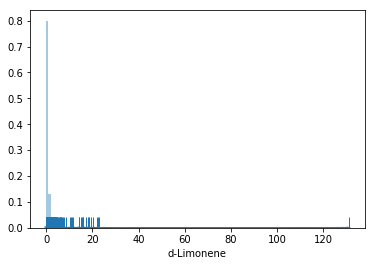

In [130]:
sns.distplot(df_terp_results['d-Limonene'], bins=130, rug=True)
print(df_terp_results[(df_terp_results['d-Limonene'] > 100)])
print(df_hm_terp_results[(df_hm_terp_results['d-Limonene'] > 100)])
print(df_hm_results[(df_hm_results['Lead'] > 100)])
print(df_hm_terp_results[(df_hm_terp_results['Lead'] > 100)])

In [99]:
print(df_terp_results['d-Limonene'])

0       0.55313
1       0.51969
2       0.16287
3       0.04565
4       0.85496
5       1.04355
6       0.20004
7       0.11657
8       0.66443
9       0.61085
10      0.08420
11      0.78589
12      0.55195
13      1.04260
14      3.36724
15      1.83070
16      0.93990
17      1.15313
18      0.56642
19      0.99606
20      1.26060
21      1.29227
22      0.00000
23      2.05835
24      0.47921
25      1.50666
26      0.97803
27      0.00000
28      0.72698
29      1.21432
         ...   
1786    0.73332
1787    1.76890
1788    1.70066
1789    1.70307
1790    1.85328
1791    1.67062
1792    1.59828
1793    1.24060
1794    0.87493
1795    1.58458
1796    1.36694
1797    1.16941
1798    1.52454
1799    0.50356
1800    1.39383
1801    1.37610
1802    0.63873
1803    0.69632
1804    0.43636
1805    0.77278
1806    0.79566
1807    0.63931
1808    0.68148
1809    0.79137
1810    1.01341
1811    0.53649
1812    1.21659
1813    1.02780
1814    0.55242
1815    0.18023
Name: d-Limonene, Length

<h5>Looking at results with all heavy metal test results</h5>

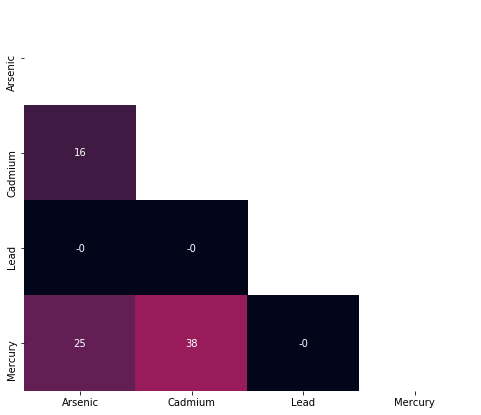

In [86]:
correlations = df_hm_results.corr()
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,7))

corr_heat = sns.heatmap(correlations * 100, annot=True, fmt='.0f', mask=mask, cbar=False)

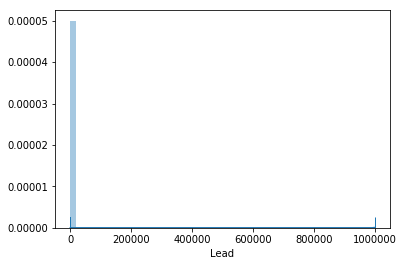

In [123]:
sns.distplot(df_hm_results['Lead'], rug=True)

           Arsenic      Cadmium         Lead      Mercury
count  3405.000000  3405.000000  3405.000000  3405.000000
mean      0.039271     0.031498     0.202060     0.009263
std       0.160765     0.127015     1.019202     0.037192
min       0.000000     0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.022000     0.000000
50%       0.012000     0.002000     0.051000     0.000000
75%       0.030000     0.024000     0.130000     0.013000
max       4.730000     3.680000    40.300000     2.000000


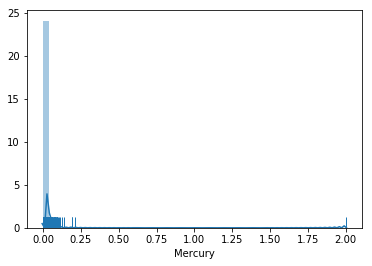

In [129]:
print(df_hm_results[(df_hm_results['Lead'] < 100)].describe())
sns.distplot(df_hm_results['Mercury'], rug=True)

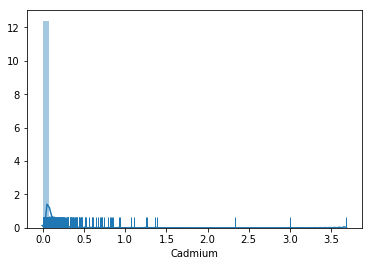

In [121]:
sns.distplot(df_hm_results['Cadmium'], rug=True)

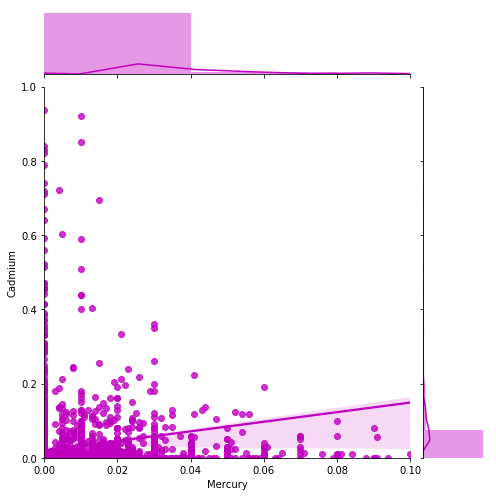

In [119]:
g = sns.jointplot("Mercury", "Cadmium", data=df_hm_results, kind="reg",
                  xlim=(0, 0.1), ylim=(0, 1), color="m", height=7)

Text(0.5,1,'Amount Mercury vs Cadmium, corr=38')

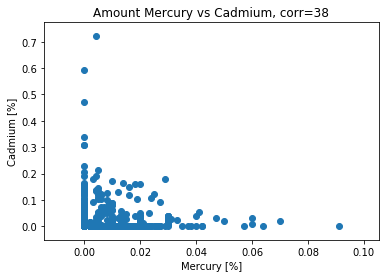

In [120]:
plt.scatter(df_hm_terp_results['Mercury'], df_hm_terp_results['Cadmium'])
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Cadmium [%]')
plt.title('Amount Mercury vs Cadmium, corr=38')

<h5>Remove data with measured analytes > 100 %</h5>

In [132]:
df_hm_results = df_hm_results[(df_hm_results['Lead'] < 100)]
df_hm_results.to_pickle('./cleaned_hm_results.pkl')

In [133]:
df_terp_results = df_terp_results[(df_terp_results['d-Limonene'] < 100)]
df_terp_results.to_pickle('./cleaned_terp_results.pkl')

<h5>Reload datasets</h5>

In [134]:
df_terp_results = pd.read_pickle("./cleaned_terp_results.pkl")
df_hm_results = pd.read_pickle("./cleaned_hm_results.pkl")

In [257]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage_heavy_metal.pdf')

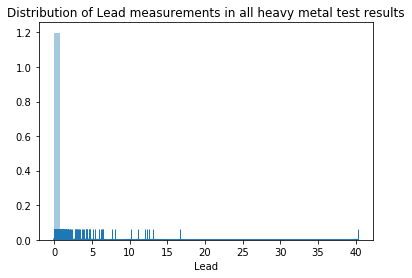

In [258]:
sns.distplot(df_hm_results['Lead'], rug=True, norm_hist=True)
plt.title('Distribution of Lead measurements in all heavy metal test results')
pp.savefig()

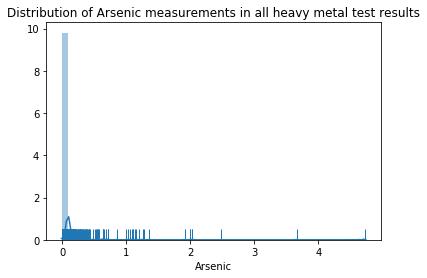

In [259]:
sns.distplot(df_hm_results['Arsenic'], rug=True, norm_hist=True)
plt.title('Distribution of Arsenic measurements in all heavy metal test results')
pp.savefig()

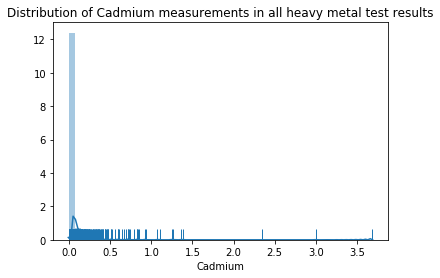

In [260]:
sns.distplot(df_hm_results['Cadmium'], rug=True, norm_hist=True)
plt.title('Distribution of Cadmium measurements in all heavy metal test results')
pp.savefig()

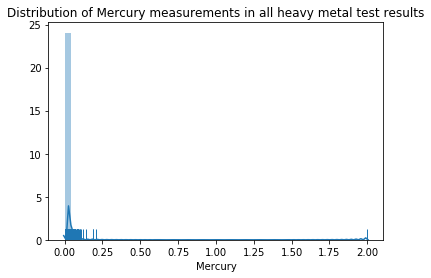

In [261]:
sns.distplot(df_hm_results['Mercury'], rug=True, norm_hist=True)
plt.title('Distribution of Mercury measurements in all heavy metal test results')
pp.savefig()

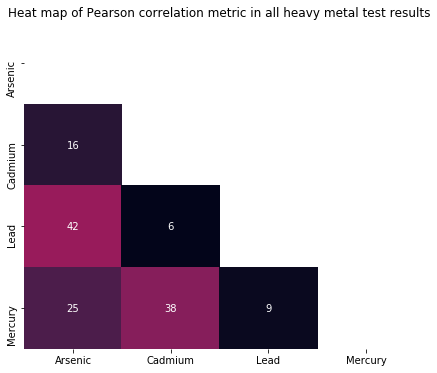

In [262]:
correlations = df_hm_results.corr()
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(7,6))
plt.title('Heat map of Pearson correlation metric in all heavy metal test results')

corr_heat = sns.heatmap(correlations * 100, annot=True, fmt='.0f', mask=mask, cbar=False)
pp.savefig()

<h5>Mercury versus Arsenic</h5>

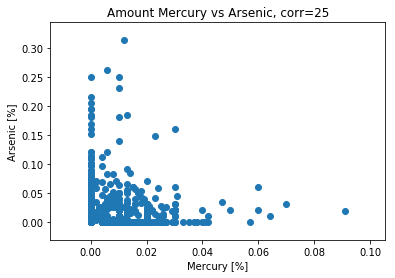

In [263]:
plt.scatter(df_hm_terp_results['Mercury'], df_hm_terp_results['Arsenic'])
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Arsenic [%]')
plt.title('Amount Mercury vs Arsenic, corr=25')
pp.savefig()

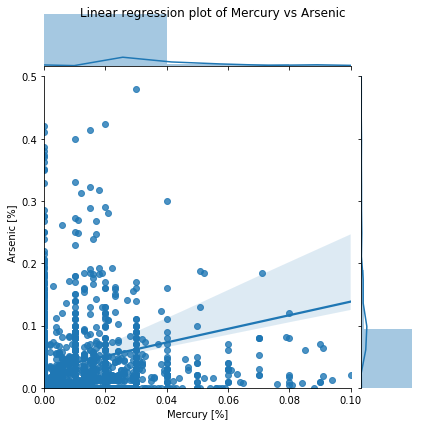

In [264]:
fig = sns.jointplot("Mercury", "Arsenic", data=df_hm_results, kind="reg",
                xlim=(0, 0.1), ylim=(0, 0.5))
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Arsenic [%]')
plt.suptitle('Linear regression plot of Mercury vs Arsenic')
pp.savefig()

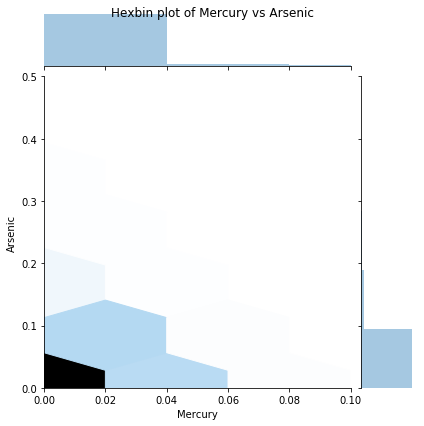

In [265]:
sns.jointplot("Mercury", "Arsenic", data=df_hm_results, kind="hex",
                xlim=(0, 0.1), ylim=(0, 0.5))
fig_size = [7,6]
#plt.xlabel('Mercury [%]')
#plt.ylabel('Arsenic [%]')
plt.suptitle('Hexbin plot of Mercury vs Arsenic')
pp.savefig()

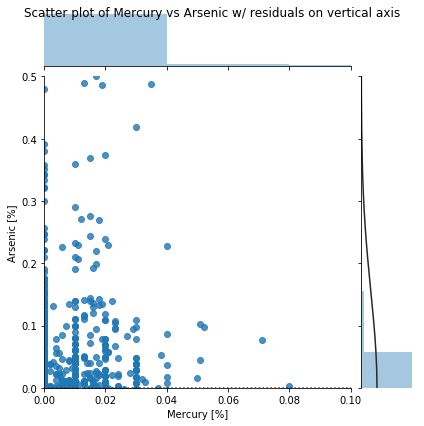

In [266]:
sns.jointplot("Mercury", "Arsenic", data=df_hm_results, kind="resid",
                xlim=(0, 0.1), ylim=(0, 0.5))
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Arsenic [%]')
plt.suptitle('Scatter plot of Mercury vs Arsenic w/ residuals on vertical axis')
pp.savefig()

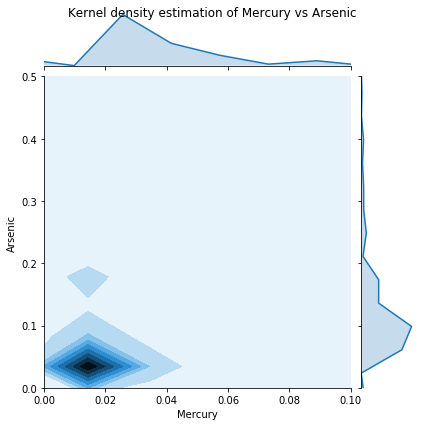

In [267]:
sns.jointplot("Mercury", "Arsenic", data=df_hm_results, kind="kde",
                xlim=(0, 0.1), ylim=(0, 0.5))
fig_size = [7,6]
#plt.xlabel('Mercury [%]')
#plt.ylabel('Arsenic [%]')
plt.suptitle('Kernel density estimation of Mercury vs Arsenic')
pp.savefig()

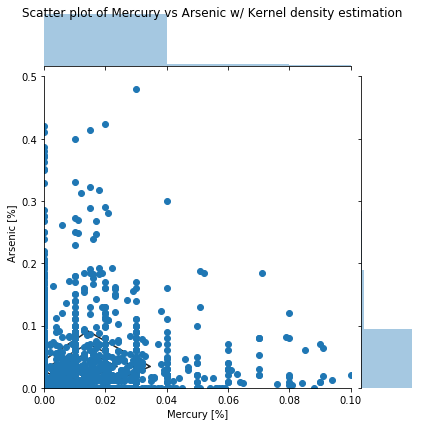

In [268]:
sns.jointplot("Mercury", "Arsenic", data=df_hm_results,
                xlim=(0, 0.1), ylim=(0, 0.5)).plot_joint(sns.kdeplot, zorder=0, n_levels=6)
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Arsenic [%]')
plt.suptitle('Scatter plot of Mercury vs Arsenic w/ Kernel density estimation')
pp.savefig()

<h5>Mercury versus Cadmium</h5>

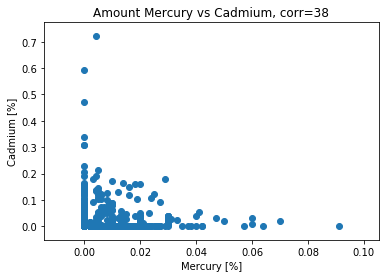

In [269]:
plt.scatter(df_hm_terp_results['Mercury'], df_hm_terp_results['Cadmium'])
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Cadmium [%]')
plt.title('Amount Mercury vs Cadmium, corr=38')
pp.savefig()

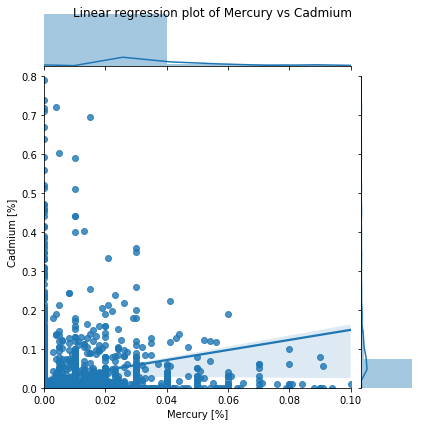

In [270]:
fig = sns.jointplot("Mercury", "Cadmium", data=df_hm_results, kind="reg",
                xlim=(0, 0.1), ylim=(0, 0.8))
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Cadmium [%]')
plt.suptitle('Linear regression plot of Mercury vs Cadmium')
pp.savefig()

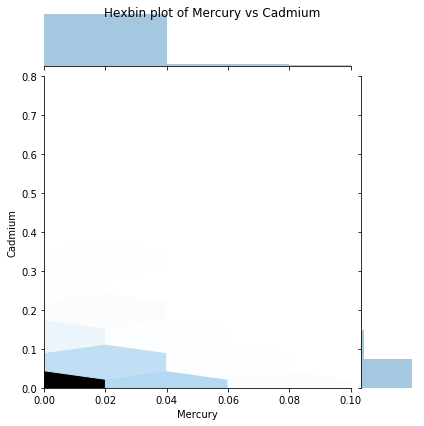

In [271]:
sns.jointplot("Mercury", "Cadmium", data=df_hm_results, kind="hex",
                xlim=(0, 0.1), ylim=(0, 0.8))
fig_size = [7,6]
#plt.xlabel('Mercury [%]')
#plt.ylabel('Arsenic [%]')
plt.suptitle('Hexbin plot of Mercury vs Cadmium')
pp.savefig()

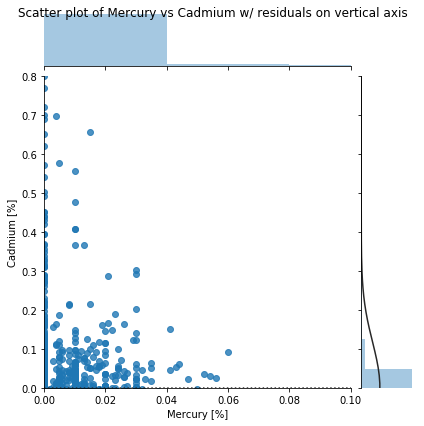

In [272]:
sns.jointplot("Mercury", "Cadmium", data=df_hm_results, kind="resid",
                xlim=(0, 0.1), ylim=(0, 0.8))
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Cadmium [%]')
plt.suptitle('Scatter plot of Mercury vs Cadmium w/ residuals on vertical axis')
pp.savefig()

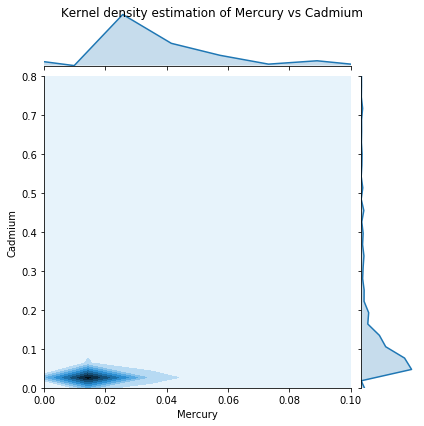

In [273]:
sns.jointplot("Mercury", "Cadmium", data=df_hm_results, kind="kde",
                xlim=(0, 0.1), ylim=(0, 0.8))
fig_size = [7,6]
#plt.xlabel('Mercury [%]')
#plt.ylabel('Arsenic [%]')
plt.suptitle('Kernel density estimation of Mercury vs Cadmium')
pp.savefig()

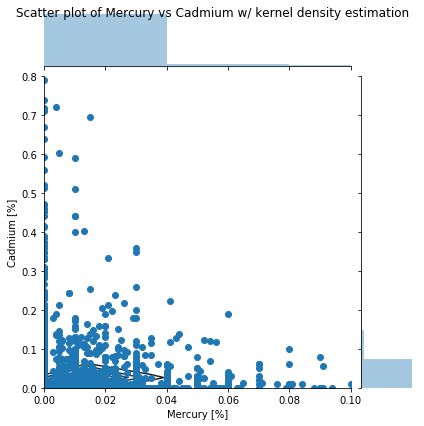

In [274]:
sns.jointplot("Mercury", "Cadmium", data=df_hm_results,
                xlim=(0, 0.1), ylim=(0, 0.8)).plot_joint(sns.kdeplot, zorder=0, n_levels=6)
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Cadmium [%]')
plt.suptitle('Scatter plot of Mercury vs Cadmium w/ kernel density estimation')
pp.savefig()

<h5>Mercury versus Lead<h5>

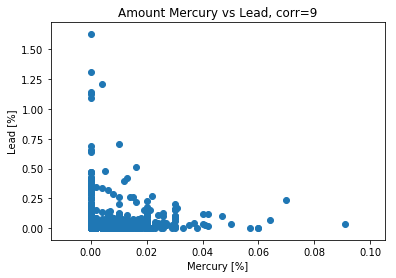

In [275]:
plt.scatter(df_hm_terp_results['Mercury'], df_hm_terp_results['Lead'])
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Lead [%]')
plt.title('Amount Mercury vs Lead, corr=9')
pp.savefig()

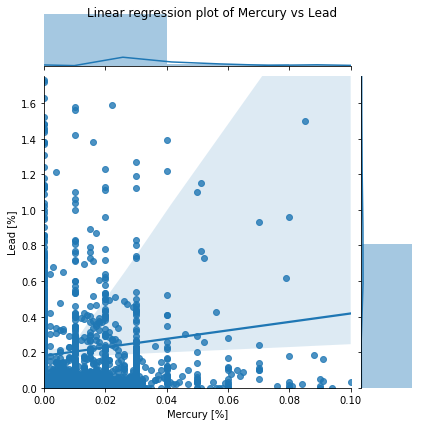

In [276]:
fig = sns.jointplot("Mercury", "Lead", data=df_hm_results, kind="reg",
                xlim=(0, 0.1), ylim=(0, 1.75))
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Lead [%]')
plt.suptitle('Linear regression plot of Mercury vs Lead')
pp.savefig()

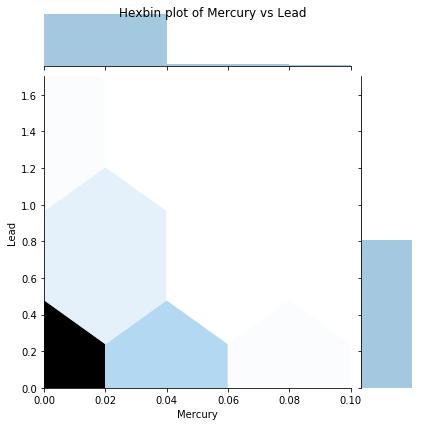

In [277]:
sns.jointplot("Mercury", "Lead", data=df_hm_results, kind="hex",
                xlim=(0, 0.1), ylim=(0, 1.7))
fig_size = [7,6]
#plt.xlabel('Mercury [%]')
#plt.ylabel('Arsenic [%]')
plt.suptitle('Hexbin plot of Mercury vs Lead')
pp.savefig()

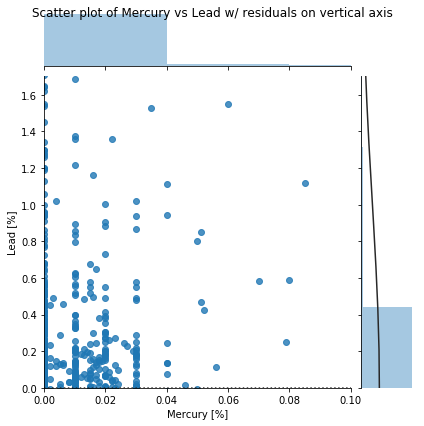

In [278]:
sns.jointplot("Mercury", "Lead", data=df_hm_results, kind="resid",
                xlim=(0, 0.1), ylim=(0, 1.7))
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Lead [%]')
plt.suptitle('Scatter plot of Mercury vs Lead w/ residuals on vertical axis')
pp.savefig()

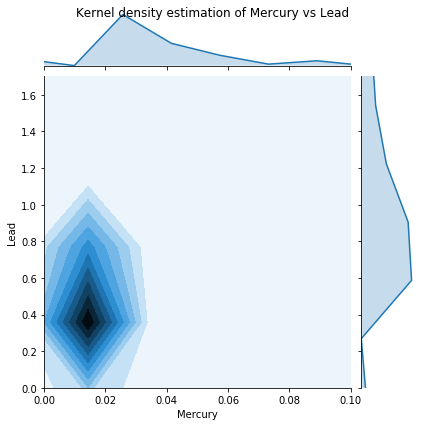

In [279]:
sns.jointplot("Mercury", "Lead", data=df_hm_results, kind="kde",
                xlim=(0, 0.1), ylim=(0, 1.7))
fig_size = [7,6]
#plt.xlabel('Mercury [%]')
#plt.ylabel('Arsenic [%]')
plt.suptitle('Kernel density estimation of Mercury vs Lead')
pp.savefig()

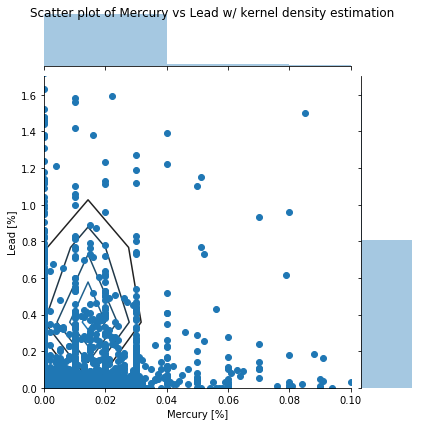

In [280]:
sns.jointplot("Mercury", "Lead", data=df_hm_results,
                xlim=(0, 0.1), ylim=(0, 1.7)).plot_joint(sns.kdeplot, zorder=0, n_levels=6)
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Lead [%]')
plt.suptitle('Scatter plot of Mercury vs Lead w/ kernel density estimation')
pp.savefig()

<h5>Lead versus Arsenic</h5>

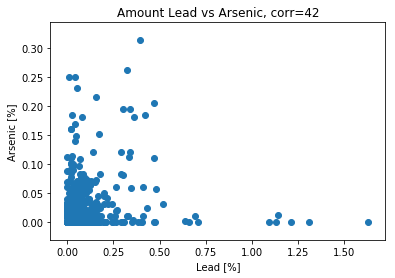

In [281]:
plt.scatter(df_hm_terp_results['Lead'], df_hm_terp_results['Arsenic'])
fig_size = [7,6]
plt.xlabel('Lead [%]')
plt.ylabel('Arsenic [%]')
plt.title('Amount Lead vs Arsenic, corr=42')
pp.savefig()

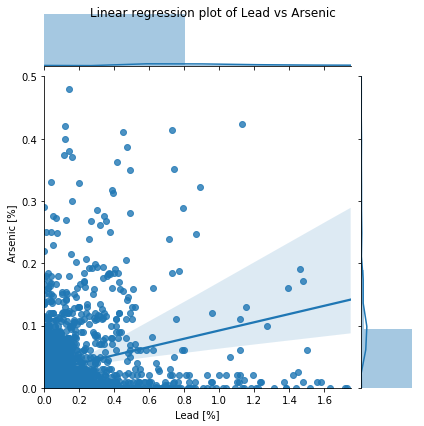

In [282]:
fig = sns.jointplot("Lead", "Arsenic", data=df_hm_results, kind="reg",
                xlim=(0, 1.75), ylim=(0, 0.5))
fig_size = [7,6]
plt.xlabel('Lead [%]')
plt.ylabel('Arsenic [%]')
plt.suptitle('Linear regression plot of Lead vs Arsenic')
pp.savefig()

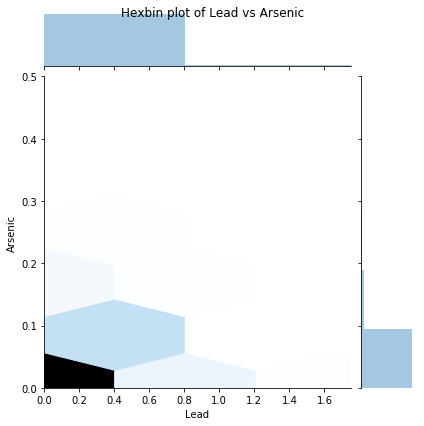

In [283]:
sns.jointplot("Lead", "Arsenic", data=df_hm_results, kind="hex",
                xlim=(0, 1.75), ylim=(0, 0.5))
fig_size = [7,6]
#plt.xlabel('Mercury [%]')
#plt.ylabel('Arsenic [%]')
plt.suptitle('Hexbin plot of Lead vs Arsenic')
pp.savefig()

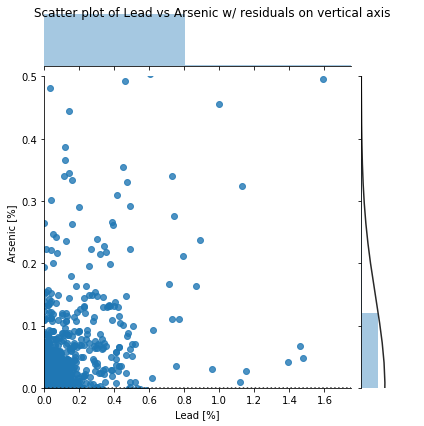

In [284]:
sns.jointplot("Lead", "Arsenic", data=df_hm_results, kind="resid",
                xlim=(0, 1.75), ylim=(0, 0.5))
fig_size = [7,6]
plt.xlabel('Lead [%]')
plt.ylabel('Arsenic [%]')
plt.suptitle('Scatter plot of Lead vs Arsenic w/ residuals on vertical axis')
pp.savefig()

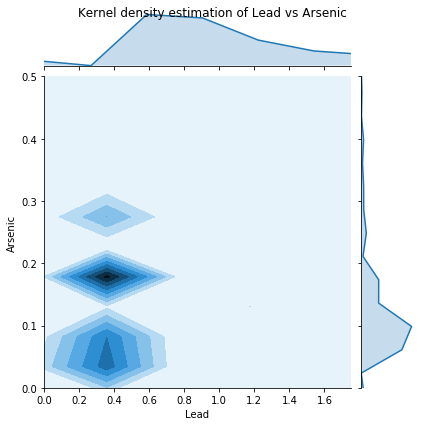

In [285]:
sns.jointplot("Lead", "Arsenic", data=df_hm_results, kind="kde",
                xlim=(0, 1.75), ylim=(0, 0.5))
fig_size = [7,6]
#plt.xlabel('Mercury [%]')
#plt.ylabel('Arsenic [%]')
plt.suptitle('Kernel density estimation of Lead vs Arsenic')
pp.savefig()

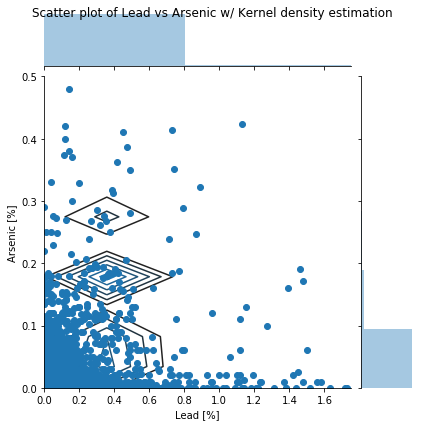

In [286]:
sns.jointplot("Lead", "Arsenic", data=df_hm_results,
                xlim=(0, 1.75), ylim=(0, 0.5)).plot_joint(sns.kdeplot, zorder=0, n_levels=6)
fig_size = [7,6]
plt.xlabel('Lead [%]')
plt.ylabel('Arsenic [%]')
plt.suptitle('Scatter plot of Lead vs Arsenic w/ Kernel density estimation')
pp.savefig()

<h5>Lead versus Cadmium</h5>

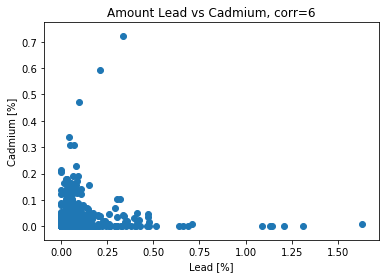

In [287]:
plt.scatter(df_hm_terp_results['Lead'], df_hm_terp_results['Cadmium'])
fig_size = [7,6]
plt.xlabel('Lead [%]')
plt.ylabel('Cadmium [%]')
plt.title('Amount Lead vs Cadmium, corr=6')
pp.savefig()

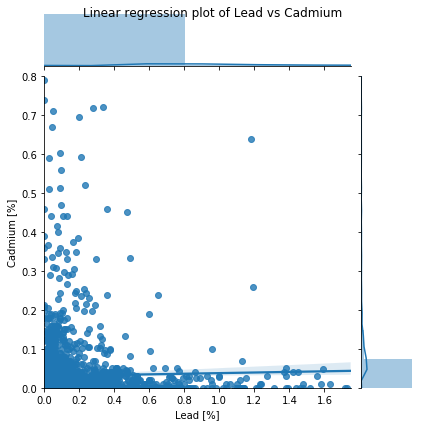

In [288]:
fig = sns.jointplot("Lead", "Cadmium", data=df_hm_results, kind="reg",
                xlim=(0, 1.75), ylim=(0, 0.8))
fig_size = [7,6]
plt.xlabel('Lead [%]')
plt.ylabel('Cadmium [%]')
plt.suptitle('Linear regression plot of Lead vs Cadmium')
pp.savefig()

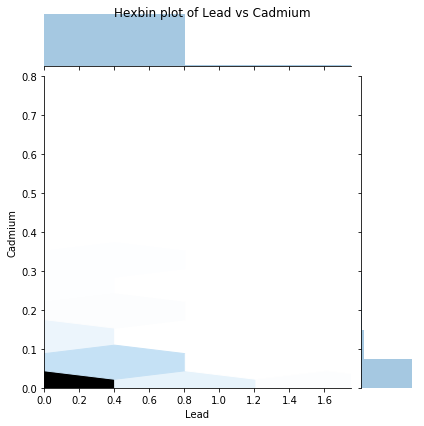

In [289]:
sns.jointplot("Lead", "Cadmium", data=df_hm_results, kind="hex",
                xlim=(0, 1.75), ylim=(0, 0.8))
fig_size = [7,6]
#plt.xlabel('Mercury [%]')
#plt.ylabel('Arsenic [%]')
plt.suptitle('Hexbin plot of Lead vs Cadmium')
pp.savefig()

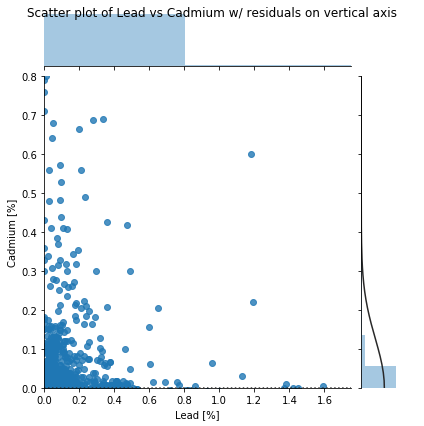

In [290]:
sns.jointplot("Lead", "Cadmium", data=df_hm_results, kind="resid",
                xlim=(0, 1.75), ylim=(0, 0.8))
fig_size = [7,6]
plt.xlabel('Lead [%]')
plt.ylabel('Cadmium [%]')
plt.suptitle('Scatter plot of Lead vs Cadmium w/ residuals on vertical axis')
pp.savefig()

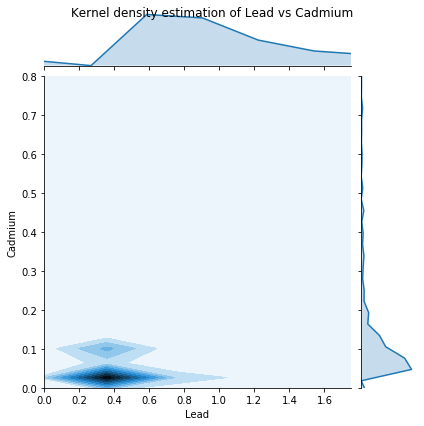

In [291]:
sns.jointplot("Lead", "Cadmium", data=df_hm_results, kind="kde",
                xlim=(0, 1.75), ylim=(0, 0.8))
fig_size = [7,6]
#plt.xlabel('Mercury [%]')
#plt.ylabel('Arsenic [%]')
plt.suptitle('Kernel density estimation of Lead vs Cadmium')
pp.savefig()

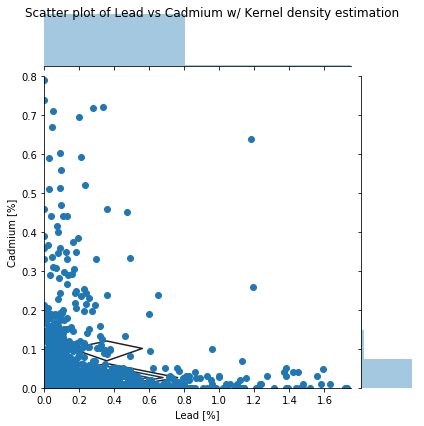

In [292]:
sns.jointplot("Lead", "Cadmium", data=df_hm_results,
                xlim=(0, 1.75), ylim=(0, 0.8)).plot_joint(sns.kdeplot, zorder=0, n_levels=6)
fig_size = [7,6]
plt.xlabel('Lead [%]')
plt.ylabel('Cadmium [%]')
plt.suptitle('Scatter plot of Lead vs Cadmium w/ Kernel density estimation')
pp.savefig()

<h5>Cadmium versus Arsenic</h5>

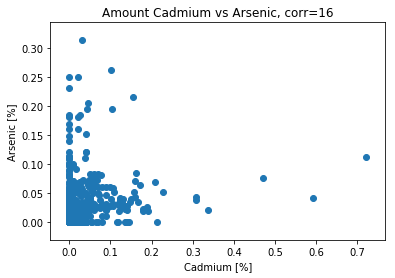

In [293]:
plt.scatter(df_hm_terp_results['Cadmium'], df_hm_terp_results['Arsenic'])
fig_size = [7,6]
plt.xlabel('Cadmium [%]')
plt.ylabel('Arsenic [%]')
plt.title('Amount Cadmium vs Arsenic, corr=16')
pp.savefig()

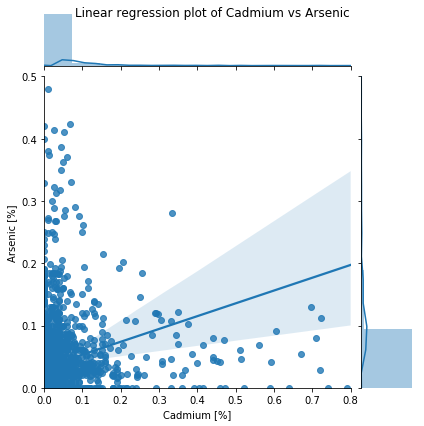

In [294]:
fig = sns.jointplot("Cadmium", "Arsenic", data=df_hm_results, kind="reg",
                xlim=(0, 0.8), ylim=(0, 0.5))
fig_size = [7,6]
plt.xlabel('Cadmium [%]')
plt.ylabel('Arsenic [%]')
plt.suptitle('Linear regression plot of Cadmium vs Arsenic')
pp.savefig()

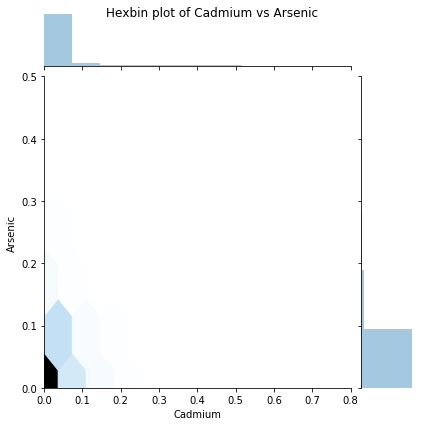

In [295]:
sns.jointplot("Cadmium", "Arsenic", data=df_hm_results, kind="hex",
                xlim=(0, 0.8), ylim=(0, 0.5))
fig_size = [7,6]
#plt.xlabel('Mercury [%]')
#plt.ylabel('Arsenic [%]')
plt.suptitle('Hexbin plot of Cadmium vs Arsenic')
pp.savefig()

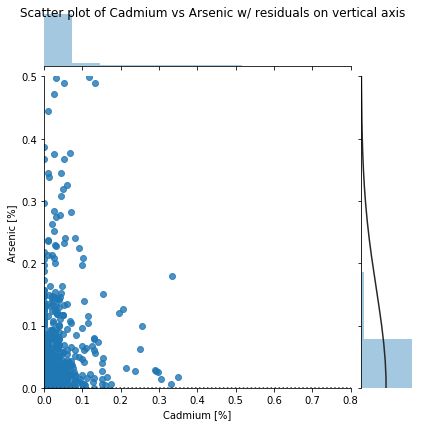

In [296]:
sns.jointplot("Cadmium", "Arsenic", data=df_hm_results, kind="resid",
                xlim=(0, 0.8), ylim=(0, 0.5))
fig_size = [7,6]
plt.xlabel('Cadmium [%]')
plt.ylabel('Arsenic [%]')
plt.suptitle('Scatter plot of Cadmium vs Arsenic w/ residuals on vertical axis')
pp.savefig()

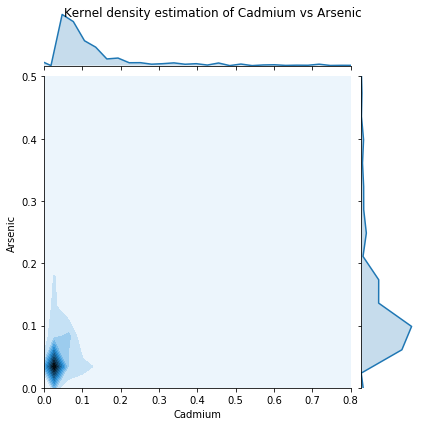

In [297]:
sns.jointplot("Cadmium", "Arsenic", data=df_hm_results, kind="kde",
                xlim=(0, 0.8), ylim=(0, 0.5))
fig_size = [7,6]
#plt.xlabel('Mercury [%]')
#plt.ylabel('Arsenic [%]')
plt.suptitle('Kernel density estimation of Cadmium vs Arsenic')
pp.savefig()

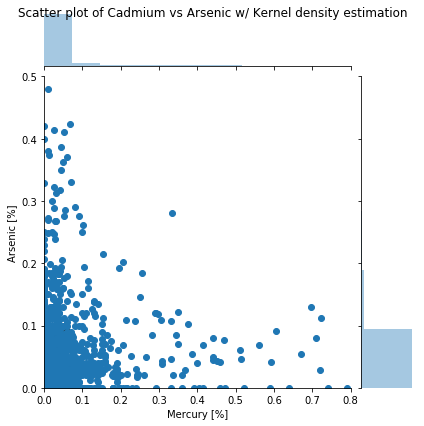

In [298]:
sns.jointplot("Cadmium", "Arsenic", data=df_hm_results,
                xlim=(0, 0.8), ylim=(0, 0.5)).plot_joint(sns.kdeplot, zorder=0, n_levels=6)
fig_size = [7,6]
plt.xlabel('Mercury [%]')
plt.ylabel('Arsenic [%]')
plt.suptitle('Scatter plot of Cadmium vs Arsenic w/ Kernel density estimation')
pp.savefig()

In [14]:
#pp.close()

In [13]:
print(df_hm_results.describe())

           Arsenic      Cadmium         Lead      Mercury
count  3405.000000  3405.000000  3405.000000  3405.000000
mean      0.039271     0.031498     0.202060     0.009263
std       0.160765     0.127015     1.019202     0.037192
min       0.000000     0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.022000     0.000000
50%       0.012000     0.002000     0.051000     0.000000
75%       0.030000     0.024000     0.130000     0.013000
max       4.730000     3.680000    40.300000     2.000000


In [ ]:
sns.distplot(df_hm_results['Arsenic'], rug=True, norm_hist=True)
plt.title('Distribution of Arsenic measurements in all heavy metal test results')
pp.savefig()